In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from investmon import tinkoff
#from ta.trend import ema_indicator

%matplotlib widget

In [15]:
report = pd.read_excel('reports/220402_report.xlsx', sheet_name='Сделки', index_col=0) 

@interact(Тикер=np.sort(report['Тикер'].unique()))
def show_articles_more_than(Тикер="GMKN"):
    
    return report.loc[(report['Тикер'] == Тикер)]

interactive(children=(Dropdown(description='Тикер', index=15, options=('AFKS', 'AFLT', 'AMD_SPB', 'BABA_SPB', …

In [22]:
from datetime import datetime
instruments = tinkoff.get_all_instruments()

@interact(Тикер=np.sort(report['Тикер'].unique()))
def show_articles_more_than(Тикер="VTBX"):
    instrument = instruments.loc[Тикер]
    
    # Расчёт средней цены
    n = 0
    avg_price = 0
    data = report.loc[(report['Тикер'] == Тикер)]
    for i, t in data.iterrows():
        if t['Операция'] == 'S':
            n -= t['Количество']
            avg_price -= t['Стоимость']
        else:
            n += t['Количество']
            avg_price += t['Стоимость']
    
    cost = avg_price
    avg_price /= n
    tmin = data['Время'].min()
    tmax = data['Время'].max()
    
    candles = tinkoff.get_candles(instrument.loc['figi'], tmin)
    
    #candles['ema 12'] = ema_indicator(close=candles['Цена закрытия'], window=12)
    
    last_price = candles.iloc[-1,:]['Цена закрытия']
    cur_cost = last_price * n
    profit = cur_cost - cost
    percentage = (profit / cost) * 100
    
    fig = plt.figure(figsize=(15,10))
    fig.canvas.header_visible = False
    plt.title(f"{instrument['Имя']}\nЗатраты: {cost:.0f}  Текущая стоимость: {cur_cost:.0f}  Прибыль: {profit:.0f} ({percentage:.0f}%)")
    plt.plot('Время', 'Цена закрытия', color='lightblue', data=candles, label=f'Цена закрытия', zorder=0);
    #plt.plot('Время', 'ema 12', color='lightgreen', data=candles, label=f'EMA 12', zorder=1);
    plt.axhline(y=avg_price, color='plum', linestyle='--', lw=2, label=f'Средняя цена: {avg_price:.2f}', zorder=5)
    plt.axhline(y=last_price, color='darkblue', linestyle='-', label=f'Последняя цена: {last_price:.2f}', zorder=5)
    plt.scatter('Время', 'Цена', c='green', marker='^', data=report.loc[(report['Тикер'] == Тикер) & (report['Операция'] == 'B')], label="Покупки", zorder=10)
    plt.scatter('Время', 'Цена', c='red', marker='v', data=report.loc[(report['Тикер'] == Тикер) & (report['Операция'] == 'S')], label="Продажи", zorder=20)
    plt.xlabel("Время")
    plt.ylabel("Цена")
    plt.grid()
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='Тикер', index=46, options=('AFKS', 'AFLT', 'AMD_SPB', 'BABA_SPB', …

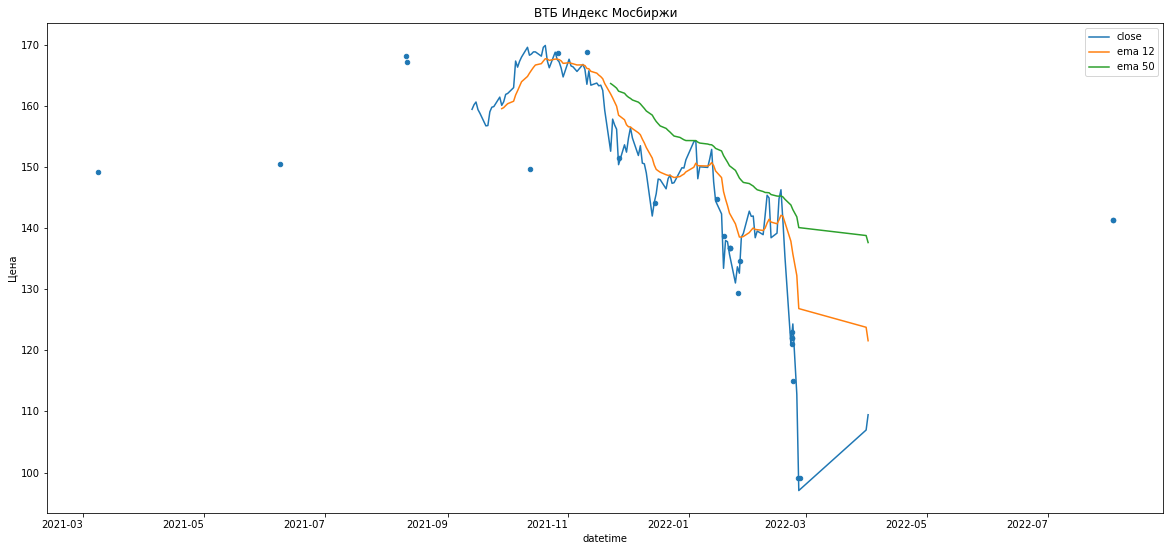

In [28]:
from datetime import datetime, timedelta
 
from pandas import DataFrame
from ta.trend import ema_indicator
from tinkoff.invest import Client, RequestError, CandleInterval, HistoricCandle, schemas
from tinkoff.invest.schemas import InstrumentIdType
from tinkoff.invest.token import TOKEN

import creds
import pandas as pd
import matplotlib.pyplot as plt
 
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

def cast_money(v):
    """
    https://tinkoff.github.io/investAPI/faq_custom_types/
    :param v:
    :return:
    """
    return v.units + v.nano / 1e9 # nano - 9 нулей

def create_df(candles : [HistoricCandle]):
    df = DataFrame([{
        'time': c.time,
        'volume': c.volume,
        'open': cast_money(c.open),
        'close': cast_money(c.close),
        'high': cast_money(c.high),
        'low': cast_money(c.low),
    } for c in candles])
 
    return df

with Client(TOKEN) as client:
    r = client.market_data.get_candles(
        figi=instrument.loc['figi'],
        from_=datetime.utcnow() - timedelta(days=200),
        to=datetime.utcnow(),
        interval=CandleInterval.CANDLE_INTERVAL_DAY # см. utils.get_all_candles
    )
    # print(r)

    df = create_df(r.candles)
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.ema_indicator
    df['ema 12'] = ema_indicator(close=df['close'], window=12)
    df['ema 50'] = ema_indicator(close=df['close'], window=50)

    #print(df[['time', 'close', 'ema']].tail(10))
   
    
    ax=df.plot(x='time', y='close', title=instrument.loc['Имя'], figsize=(20,10))
    df.plot(ax=ax, x='time', y='ema 12')
    df.plot(ax=ax, x='time', y='ema 50')
    rr.plot.scatter(ax=ax, x='Время', y='Цена')
    plt.show()
    
    
    

In [ ]:
from datetime import datetime, timedelta

from tinkoff.invest import CandleInterval, Client

with Client(TOKEN) as client:
    pf = client.instruments.currencies;
    print(pf.)


In [300]:
# Импорт отчетов ВТБ
columns=['textBox16','textBox14','textBox1','textBox17','textBox45','textBox12',
         'textBox18','textBox19','textBox20', 'textBox25']
A6V = pd.read_csv('./220329_100A6V_позиции.csv', header=0, delimiter=',')[columns]  
A6V["Брокер"] = "Альфа"
A6U = pd.read_csv('./220329_100A6U_позиции.csv', header=0, delimiter=',')[columns] 
A6U["Брокер"] = "ВТБ"
report = A6V.append(A6U)
report['datetime'] = pd.to_datetime(report['textBox45'] + ' ' + report['textBox12'])
names={'textBox14': 'Тикер', 
         'textBox1': 'Актив',
         'textBox16': '№ Сделки',
         'textBox17': 'Операция',
         'textBox45': 'Дата',
         'textBox12': 'Время',
         'textBox18': 'Цена',
         'textBox19': 'Количество',
         'textBox20': 'Стоимость (руб.)',
         'textBox25': 'Комиссия',
}
report.rename(columns=names, inplace=True)
report['Цена'] = report['Цена'].str.replace('\s+', '', regex=True).astype(float)
report.insert(8, 'Стоимость', None);
report.insert(9, 'Валюта', '₽');
report['Стоимость (руб.)'] = report['Стоимость (руб.)'].str.replace('\s+', '', regex=True).astype(float)

report['Количество'] = report['Количество'].str.replace('\s+', '', regex=True).astype(int)
report['Стоимость'] = report['Цена'] * report['Количество']
report['Комиссия'] = report['Комиссия'].astype(float)
report['Актив'].fillna(report['Тикер'], inplace=True)
report.set_index('№ Сделки', inplace=True)

In [301]:
# Импорт отчетов Тинькоф
tinkof = pd.read_csv('./220330_Тиньков.csv')
tinkof.dropna(how='all', axis=1, inplace=True)

names={'Номер сделки': '№ Сделки', 
         'Дата заклю\nчения': 'Дата',
         'Вид сделки': 'Операция',
         'Код актива': 'Тикер',
         'Сокращен\nное наименова\nние актива': 'Актив',
         'Цена за едини\nцу': 'Цена',
         'Комиссия биржи': 'Комиссия',
         'Валю\nта цены': 'Валюта',
         'Время': 'Время',
         'Количество': 'Количество',
         'Сумма сделки': 'Стоимость',
}
tinkof.drop(columns=tinkof.columns.difference(list(names.keys())), inplace=True)
tinkof.rename(columns=names, inplace=True)
tinkof['datetime'] = pd.to_datetime(tinkof['Дата'] + ' ' + tinkof['Время'])
tinkof.set_index('№ Сделки', inplace=True)

currency = {'RUB': '₽', 'USD': '$'}
operations = {'Покупка': 'B', 'Продажа': 'S'}
tinkof.replace({"Валюта": currency, "Операция": operations}, inplace=True)
tinkof['Цена'] = tinkof['Цена'].astype(str).replace(',', '.', regex=True).astype(float)
tinkof['Стоимость'] = tinkof['Стоимость'].astype(str).replace(',', '.', regex=True).astype(float)
tinkof['Количество'] = tinkof['Количество'].astype(int)
tinkof['Комиссия'] = tinkof['Комиссия'].astype(float)
tinkof["Брокер"] = "Тиньков"
report = report.append(tinkof)

In [302]:
report.sort_values(['datetime'], inplace=True)
writer = pd.ExcelWriter('report.xlsx')
report.to_excel(writer, sheet_name='Сделки')
wb = writer.book
ws = writer.sheets['Сделки']

ws.set_column_pixels('B:B', 150)
ws.set_column_pixels('C:C', 150)
ws.set_column_pixels('E:E', 100)
ws.set_column_pixels('I:I', 100)

left_fmt = wb.add_format({'align': 'left'})
center_fmt = wb.add_format({'align': 'center'})
money_fmt = wb.add_format({'num_format': '0.00', 'align': 'right', 'text_wrap': True})
rub_fmt = wb.add_format({'num_format': '0.00 ₽', 'align': 'right', 'text_wrap': True})
ws.set_column('A:A', 20, center_fmt)
ws.set_column('D:D', 10, center_fmt)
ws.set_column('E:E', 10, center_fmt)
ws.set_column('L:L', 10, center_fmt)
ws.set_column('G:G', 10, money_fmt)
ws.set_column('H:H', 10, left_fmt)
ws.set_column('J:J', 15, rub_fmt)
ws.set_column('K:K', 15, rub_fmt)
ws.freeze_panes(1, 3)
ws.autofilter('B1:L1')
writer.save()

report

,Тикер,Актив,Операция,Дата,Время,Цена,Количество,Стоимость,Валюта,Стоимость (руб.),Комиссия,Брокер,datetime
№ Сделки,,,,,,,,,,,,,
3049109453,SBER,Сбербанк а.о. 3,B,02.12.2019,11:17:39,235.6000,50,11780.0,₽,11780.0,5.63,Альфа,2019-02-12 11:17:39
3049239790,VTBR,ВТБ осн,B,02.12.2019,12:26:42,0.0453,200000,9060.0,₽,9060.0,4.33,Альфа,2019-02-12 12:26:42
3049255789,GAZP,Газпром а.о.,B,02.12.2019,12:39:40,261.0800,10,2610.8,₽,2610.8,1.25,Альфа,2019-02-12 12:39:40
3049255799,GAZP,Газпром а.о.,B,02.12.2019,12:39:41,261.0800,10,2610.8,₽,2610.8,1.25,Альфа,2019-02-12 12:39:41
3049255803,GAZP,Газпром а.о.,B,02.12.2019,12:39:41,261.0800,10,2610.8,₽,2610.8,1.25,Альфа,2019-02-12 12:39:41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
M038209989,FXGD,FXGD ETF,B,03.02.2022,6:00:01,87.7200,100,8772.0,₽,8772.0,4.18,Альфа,2022-03-02 06:00:01
M038209986,FXGD,FXGD ETF,B,03.02.2022,6:00:01,63.9800,60,3838.8,₽,3838.8,1.83,Альфа,2022-03-02 06:00:01
4964347473,VTBA,VTBA ETF,B,08.02.2022,17:55:46,115.9900,200,23198.0,₽,23198.0,2.32,Альфа,2022-08-02 17:55:46
